## Triple Barrier Method

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import yfinance as yf

In [29]:
from alphapy.globals import BarType
from alphapy.metalabel import add_vertical_barrier
from alphapy.metalabel import get_bins
from alphapy.metalabel import get_daily_dollar_vol
from alphapy.metalabel import get_daily_vol
from alphapy.metalabel import get_events
from alphapy.metalabel import get_t_events
from alphapy.variables import map_bar_type

In [30]:
stock = 'TSLA'
stock_info = yf.Ticker(stock)

In [31]:
data_history = 1000
fractal = 'd'
period = ''.join([str(data_history), fractal])
period

'1000d'

In [32]:

df = stock_info.history(period=period)

In [33]:
df.reset_index(inplace=True)
df.columns = map(str.lower, df.columns)
df.rename(columns={'date' : 'datetime'}, inplace=True)
df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]

In [34]:
df.set_index('datetime', inplace=True)

In [35]:
df

,open,high,low,close,volume
datetime,,,,,
2018-12-21,21.160000,21.564667,20.829332,21.318001,120252000
2018-12-24,20.900000,20.966667,19.680000,19.692667,83398500
2018-12-26,20.000000,21.798000,19.606001,21.739332,122446500
2018-12-27,21.322666,21.478001,20.100000,21.075333,128626500
2018-12-28,21.540001,22.416000,21.227333,22.257999,149085000
...,...,...,...,...,...
2022-12-05,189.440002,191.270004,180.550003,182.449997,93122700
2022-12-06,181.220001,183.649994,175.330002,179.820007,92150800
2022-12-07,175.029999,179.380005,172.220001,174.039993,84213300


In [36]:
ddv = get_daily_dollar_vol(df)
ddv

18617625273.023773

In [37]:
use_dollar_bars = False
if use_dollar_bars:
    dollar_bars = map_bar_type(df, BarType.dollar, '1D', pv_factor=2.0)

In [38]:
def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [39]:
# compute bands
window = 50
df['avg'], df['upper'], df['lower'] = bbands(df['close'], window, no_of_stdev=1.5)

# compute sides
df['side'] = np.nan
long_signals = (df['close'] <= df['lower'])
short_signals = (df['close'] >= df['upper'])
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

print(df.side.value_counts())

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

# Drop the NaN values from our data set
#df.dropna(axis=0, how='any', inplace=True)  

-1.0    96
 1.0    43
Name: side, dtype: int64


In [40]:
daily_vol = get_daily_vol(df)
daily_vol

datetime
2018-12-26    0.125994
2018-12-27    0.091887
2018-12-28    0.080206
2018-12-31    0.069430
2019-01-02    0.069995
                ...   
2022-12-05    0.039116
2022-12-06    0.038752
2022-12-07    0.038563
2022-12-08    0.038181
2022-12-09    0.038158
Name: close, Length: 998, dtype: float64

In [41]:
cusum_events = get_t_events(df['close'], threshold=daily_vol.mean())

100%|██████████| 998/998 [00:00<00:00, 35284.88it/s]


In [42]:
cusum_events

DatetimeIndex(['2018-12-26', '2018-12-28', '2019-01-02', '2019-01-04',
               '2019-01-07', '2019-01-18', '2019-01-23', '2019-01-30',
               '2019-02-05', '2019-02-07',
               ...
               '2022-11-02', '2022-11-07', '2022-11-09', '2022-11-10',
               '2022-11-16', '2022-11-21', '2022-11-23', '2022-11-30',
               '2022-12-05', '2022-12-07'],
              dtype='datetime64[ns]', length=340, freq=None)

In [43]:
vertical_barriers = add_vertical_barrier(cusum_events, df['close'], num_days=5)

In [44]:
vertical_barriers

2018-12-26   2018-12-31
2018-12-28   2019-01-02
2019-01-02   2019-01-07
2019-01-04   2019-01-09
2019-01-07   2019-01-14
                ...    
2022-11-10   2022-11-15
2022-11-16   2022-11-21
2022-11-21   2022-11-28
2022-11-23   2022-11-28
2022-11-30   2022-12-05
Name: datetime, Length: 338, dtype: datetime64[ns]

In [45]:
pt_sl = [2, 2] # setting profit-taking and stop-loss multiples at 2 and 2
min_ret = 0.02 # setting a minimum return of 2%

In [46]:
triple_barrier_events = get_events(df['close'],
                                   cusum_events,
                                   pt_sl,
                                   daily_vol,
                                   min_ret,
                                   vertical_barriers,
                                   df['side'])

In [47]:
triple_barrier_events

,t1,trgt,side
2019-01-23,2019-01-28,0.053449,1.0
2019-03-05,2019-03-11,0.037304,1.0
2019-04-26,2019-05-01,0.031258,1.0
2019-05-02,2019-05-07,0.031109,1.0
2019-05-22,2019-05-28,0.031906,1.0
2019-10-25,2019-10-30,0.037044,-1.0
2019-11-01,2019-11-06,0.035744,-1.0
2019-11-11,2019-11-18,0.034053,-1.0
2019-12-24,2019-12-30,0.029203,-1.0
2020-01-08,2020-01-13,0.028605,-1.0


In [48]:
labels = get_bins(triple_barrier_events, df['close'])
labels.side.value_counts()  

-1.0    33
 1.0    13
Name: side, dtype: int64

In [49]:
labels.bin.value_counts()

0    33
1    13
Name: bin, dtype: int64

In [54]:
labels

,ret,trgt,bin,side
2019-01-23,0.030564,0.053449,0,1.0
2019-03-05,0.052000,0.037304,1,1.0
2019-04-26,-0.004806,0.031258,0,1.0
2019-05-02,0.012126,0.031109,0,1.0
2019-05-22,-0.020910,0.031906,0,1.0
2019-10-25,0.041649,0.037044,1,-1.0
2019-11-01,-0.040633,0.035744,0,-1.0
2019-11-11,-0.014000,0.034053,0,-1.0
2019-12-24,0.025440,0.029203,0,-1.0
2020-01-08,-0.062340,0.028605,0,-1.0


#### Primary Model Evaluation

In [51]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.28      1.00      0.44        13

    accuracy                           0.28        46
   macro avg       0.14      0.50      0.22        46
weighted avg       0.08      0.28      0.12        46

Confusion Matrix
[[ 0 33]
 [ 0 13]]

Accuracy
0.2826086956521739


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Secondary Model Evaluation

In [56]:
# Get features at event dates
X = df.loc[labels.index, :]
y = labels['bin']

In [61]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [62]:
# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.75      1.00      0.86         9

    accuracy                           0.92        36
   macro avg       0.88      0.94      0.90        36
weighted avg       0.94      0.92      0.92        36

Confusion Matrix
[[24  3]
 [ 0  9]]

Accuracy
0.9166666666666666


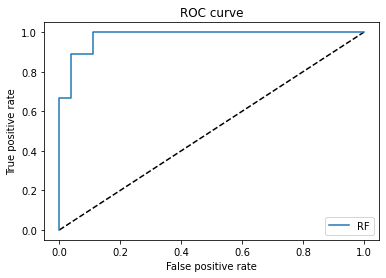

In [67]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.50      0.67         4

    accuracy                           0.80        10
   macro avg       0.88      0.75      0.76        10
weighted avg       0.85      0.80      0.78        10

Confusion Matrix
[[6 0]
 [2 2]]

Accuracy
0.8


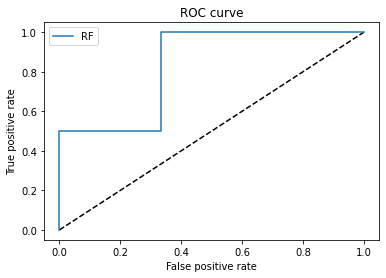

In [68]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### End of Notebook